In [3]:
# REINFORCE, VPG, A3C, GAE, A2C

In [5]:
!nvidia-smi

Sun Dec 16 23:40:54 2018       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 415.18       Driver Version: 415.18       CUDA Version: 10.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  TITAN X (Pascal)    Off  | 00000000:0B:00.0 Off |                  N/A |
| 23%   38C    P8    17W / 250W |    527MiB / 12196MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  TITAN X (Pascal)    Off  | 00000000:41:00.0 Off |                  N/A |
| 24%   42C    P8    17W / 250W |     10MiB / 12188MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
        

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import numpy as np
from IPython.display import display
from collections import namedtuple, deque
import matplotlib.pyplot as plt
from itertools import cycle, count
from textwrap import wrap

import subprocess
import os.path
import tempfile
import random
import base64
import pprint
import time
import json
import sys
import gym
import io

from gym import wrappers
from subprocess import check_output
from IPython.display import HTML

plt.style.use('fivethirtyeight')
np.set_printoptions(suppress=True)

%matplotlib inline

In [7]:
torch.cuda.is_available()

True

In [8]:
def make_monitored_env(env_name, monitor_mode, seed):
    mdir = tempfile.mkdtemp()
    env = gym.make(env_name)
    env = env.unwrapped
    env = wrappers.Monitor(env, mdir, force=True, mode=monitor_mode)
    env.seed(seed)
    return env

In [9]:
def plot_results(results, log_scale=False):
    plt.figure(figsize=(15, 10))
    lines = ["-","--",":","-."]
    linecycler = cycle(lines)
    for experiment, experiment_name, env in results:
        label = '\n'.join(wrap(experiment_name.replace('_', ', '), 50))
        plt.plot(experiment, next(linecycler), label=label)
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    if log_scale: plt.xscale('log')
    plt.ylabel('Rewards')
    plt.xlabel('Episode')
    plt.show()

In [10]:
def get_videos_html(env_videos, title, max_n_videos=3):
    videos = np.array(env_videos)
    n_videos = max(1, min(max_n_videos, len(videos)))
    idxs = np.linspace(0, len(videos) - 1, n_videos).astype(int)
    videos = videos[idxs,:]

    strm = '<h2>{}<h2>'.format(title)
    for video_path, meta_path in videos:
        video = io.open(video_path, 'r+b').read()
        encoded = base64.b64encode(video)

        with open(meta_path) as data_file:    
            meta = json.load(data_file)

        html_tag = """
        <h3>{0}<h3/>
        <video width="960" height="540" controls>
            <source src="data:video/mp4;base64,{1}" type="video/mp4" />
        </video>"""
        strm += html_tag.format('Episode ' + str(meta['episode_id']), encoded.decode('ascii'))
    return strm

In [11]:
def get_gif_html(env_videos, title, max_n_videos=3):
    videos = np.array(env_videos)
    n_videos = max(1, min(max_n_videos, len(videos)))
    idxs = np.linspace(0, len(videos) - 1, n_videos).astype(int)
    videos = videos[idxs,:]

    strm = '<h2>{}<h2>'.format(title)
    for video_path, meta_path in videos:
        basename = os.path.splitext(video_path)[0]
        gif_path = basename + '.gif'
        if not os.path.exists(gif_path):
            ps = subprocess.Popen(
                ('ffmpeg', 
                 '-i', video_path, 
                 '-r', '10', 
                 '-f', 'image2pipe', 
                 '-vcodec', 'ppm', 
                 '-'), 
                stdout=subprocess.PIPE)
            output = subprocess.check_output(
                ('convert', 
                 '-delay', '5', 
                 '-loop', '0', 
                 '-', gif_path), 
                stdin=ps.stdout)
            ps.wait()

        gif = io.open(gif_path, 'r+b').read()
        encoded = base64.b64encode(gif)
            
        with open(meta_path) as data_file:    
            meta = json.load(data_file)

        html_tag = """
        <h3>{0}<h3/>
        <img src="data:image/gif;base64,{1}" />"""
        strm += html_tag.format('Episode ' + str(meta['episode_id']), encoded.decode('ascii'))
    return strm

# Monte-Carlo REINFORCE

In [12]:
class FCDP(nn.Module):
    def __init__(self, 
                 input_dim, 
                 output_dim,
                 hidden_dims=(32,32), 
                 init_weight=0.003,
                 activation_fc=F.relu):
        super(FCDP, self).__init__()
        self.activation_fc = activation_fc

        self.input_layer = nn.Linear(input_dim, 
                                     hidden_dims[0])
        
        self.hidden_layers = nn.ModuleList()
        for i in range(len(hidden_dims)-1):
            hidden_layer = nn.Linear(
                hidden_dims[i], hidden_dims[i+1])
            self.hidden_layers.append(hidden_layer)
                
        self.output_layer = nn.Linear(
            hidden_dims[-1], output_dim)

        device = "cpu"
        if torch.cuda.is_available():
            device = "cuda:0"
        self.device = torch.device(device)
        self.to(self.device)
        
        self.output_layer.weight.data.uniform_(
            -init_weight, init_weight)
        self.output_layer.bias.data.uniform_(
            -init_weight, init_weight)


    def forward(self, state):
        x = state
        if not isinstance(x, torch.Tensor):
            x = torch.tensor(x, 
                             device=self.device, 
                             dtype=torch.float32)
            x = x.unsqueeze(0)
        x = self.activation_fc(self.input_layer(x))
        for hidden_layer in self.hidden_layers:
            x = self.activation_fc(hidden_layer(x))
        x = self.output_layer(x)
        return F.log_softmax(x, dim=-1)
    
    def select_action(self, state):
        logp = self.forward(state)
        action = torch.exp(logp).multinomial(num_samples=1).data[0].cpu().numpy()[0]
        return action, logp

In [73]:
class REINFORCEAgent():
    def __init__(self, policy_model, policy_optimizer, policy_optimizer_lr):
        self.model_fn = policy_model
        self.optimizer_fn = policy_optimizer
        self.optimizer_lr = policy_optimizer_lr
        self.print_every_episodes = 100

    def optimize_model(self):
        num_steps = len(self.rewards)
        discounts = np.logspace(0, num_steps, num=num_steps, base=self.gamma, endpoint=False)
        returns = []
        for step_idx in range(num_steps):
            last_idx = num_steps-step_idx
            returns.append(np.sum(discounts[:last_idx] * self.rewards[step_idx:]))

        self.logps = torch.cat(self.logps).cuda()
        self.actions = torch.LongTensor(self.actions)
        returns = torch.FloatTensor(returns).unsqueeze(1).cuda()
        loss = -(self.logps[np.arange(num_steps), self.actions] * returns).sum()
        
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

    def interaction_step(self, env, state):
        action, logp = self.model.select_action(state)
        new_state, reward, is_terminal, _ = env.step(action)
        self.logps.append(logp)
        self.actions.append(action)
        self.rewards.append(reward)
        
        self.episode_reward[-1] += reward
        self.episode_timestep[-1] += 1
        
        return new_state, is_terminal

    def train(self, env, gamma, max_episodes, max_mean_reward):
        self.gamma = gamma
        nS, nA = env.observation_space.shape[0], env.action_space.n
        self.episode_exploration = []
        self.episode_timestep = []
        self.episode_reward = []
        self.episode_seconds = []
        
        self.model = self.model_fn(nS, nA)
        self.model.eval()
        self.optimizer = self.optimizer_fn(self.model, self.optimizer_lr)
        
        for episode in range(1, max_episodes + 1):
            start = time.time()
            state, is_terminal = env.reset(), False
            self.episode_reward.append(0.0)
            self.episode_timestep.append(0.0)
            self.episode_exploration.append(0.0)

            # collect rollout
            self.logps, self.actions, self.rewards = [], [], []
            for timestep in count(start=1):
                state, is_terminal = self.interaction_step(env, state)
                if is_terminal:
                    break
            self.optimize_model()

            # stats
            self.episode_seconds.append(time.time() - start)
            mean_seconds = np.mean(self.episode_seconds[-100:])
            mean_reward = np.mean(self.episode_reward[-100:])
            mean_10_reward = np.mean(self.episode_reward[-25:])
            if episode % self.print_every_episodes == 0 or mean_reward >= max_mean_reward:
                episode_exploration_ratio = self.episode_exploration[-1] / self.episode_timestep[-1]
                debug_message = 'ep {:03}, tmstps {:05}, explr rat {:.2f}, buf sze {:05}, '
                debug_message += '25/100 ep av rew {:06.2f}/{:06.2f}, 100 ep av sec {:.2f}'
                debug_message = debug_message.format(
                    episode, int(np.sum(self.episode_timestep)), 
                    1, 1, 
                    mean_10_reward, mean_reward, mean_seconds)
                print(debug_message)

            if mean_reward >= max_mean_reward:
                print('Training complete')
                break

        env.close()
        return self.episode_reward
    
    def evaluate(self, env, strategy, episodes=10, render=True):
        pass

In [74]:
rewardss = []
for seed in [1, 2, 3, 4, 5]:
    environment_settings = {
        'training_env_name': 'CartPole-v0',
        'testing_env_name': 'CartPole-v0',
        'gamma': 1.00,
        'max_episodes': 5000,
        'max_mean_reward': 195,
        'print_every_episodes': 25,
        'save_every_episodes': 1500,
        'n_evaluation_episodes': 10,
    }

    policy_model = lambda nS, nA: FCDP(nS, nA, hidden_dims=(256,256))
    policy_optimizer = lambda net, lr: optim.Adam(net.parameters(), lr=lr)
    policy_optimizer_lr = 0.0003

    training_env_name, testing_env_name, gamma, max_episodes, \
      max_mean_reward, print_every_episodes, save_every_episodes, \
      n_evaluation_episodes = environment_settings.values()

    torch.manual_seed(seed)
    np.random.seed(seed)

    agent = REINFORCEAgent(policy_model, policy_optimizer, policy_optimizer_lr)

    training_env = make_monitored_env(training_env_name, 'training', seed)
    rewards = agent.train(training_env, gamma=gamma, max_episodes=max_episodes, max_mean_reward=max_mean_reward)

    rewardss.append(rewards)
mean_ep = 0
for r in rewardss:
    mean_ep += len(r)
mean_ep /= len(rewardss)
print("Mean num ep to pass {:.2f}".format(mean_ep))

/opt/conda/lib/python3.6/site-packages/gym/envs/registration.py:14: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)


ep 100, tmstps 02724, explr rat 1.00, buf sze 00001, 25/100 ep av rew 036.28/027.24, 100 ep av sec 0.04
ep 200, tmstps 07997, explr rat 1.00, buf sze 00001, 25/100 ep av rew 063.32/052.73, 100 ep av sec 0.04
ep 300, tmstps 14537, explr rat 1.00, buf sze 00001, 25/100 ep av rew 099.56/065.40, 100 ep av sec 0.05
ep 400, tmstps 33553, explr rat 1.00, buf sze 00001, 25/100 ep av rew 195.88/190.16, 100 ep av sec 0.11
ep 401, tmstps 34241, explr rat 1.00, buf sze 00001, 25/100 ep av rew 212.52/196.04, 100 ep av sec 0.11
Training complete


/opt/conda/lib/python3.6/site-packages/gym/envs/registration.py:14: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)


ep 100, tmstps 02479, explr rat 1.00, buf sze 00001, 25/100 ep av rew 028.12/024.79, 100 ep av sec 0.04
ep 200, tmstps 06276, explr rat 1.00, buf sze 00001, 25/100 ep av rew 048.24/037.97, 100 ep av sec 0.03
ep 300, tmstps 10342, explr rat 1.00, buf sze 00001, 25/100 ep av rew 045.60/040.66, 100 ep av sec 0.03
ep 400, tmstps 16725, explr rat 1.00, buf sze 00001, 25/100 ep av rew 081.12/063.83, 100 ep av sec 0.05
ep 500, tmstps 26535, explr rat 1.00, buf sze 00001, 25/100 ep av rew 045.12/098.10, 100 ep av sec 0.06
ep 600, tmstps 30117, explr rat 1.00, buf sze 00001, 25/100 ep av rew 037.56/035.82, 100 ep av sec 0.03
ep 700, tmstps 34461, explr rat 1.00, buf sze 00001, 25/100 ep av rew 047.56/043.44, 100 ep av sec 0.03
ep 800, tmstps 42219, explr rat 1.00, buf sze 00001, 25/100 ep av rew 105.24/077.58, 100 ep av sec 0.06
ep 900, tmstps 50959, explr rat 1.00, buf sze 00001, 25/100 ep av rew 022.92/087.40, 100 ep av sec 0.05
ep 1000, tmstps 53188, explr rat 1.00, buf sze 00001, 25/100 ep 

/opt/conda/lib/python3.6/site-packages/gym/envs/registration.py:14: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)


ep 100, tmstps 02055, explr rat 1.00, buf sze 00001, 25/100 ep av rew 017.64/020.55, 100 ep av sec 0.04
ep 200, tmstps 05516, explr rat 1.00, buf sze 00001, 25/100 ep av rew 041.40/034.61, 100 ep av sec 0.03
ep 300, tmstps 11620, explr rat 1.00, buf sze 00001, 25/100 ep av rew 061.88/061.04, 100 ep av sec 0.06
ep 400, tmstps 19453, explr rat 1.00, buf sze 00001, 25/100 ep av rew 092.28/078.33, 100 ep av sec 0.06
ep 500, tmstps 31493, explr rat 1.00, buf sze 00001, 25/100 ep av rew 135.64/120.40, 100 ep av sec 0.06
ep 600, tmstps 44248, explr rat 1.00, buf sze 00001, 25/100 ep av rew 113.96/127.55, 100 ep av sec 0.11
ep 700, tmstps 54379, explr rat 1.00, buf sze 00001, 25/100 ep av rew 102.08/101.31, 100 ep av sec 0.07
ep 800, tmstps 67343, explr rat 1.00, buf sze 00001, 25/100 ep av rew 136.20/129.64, 100 ep av sec 0.09
ep 900, tmstps 81365, explr rat 1.00, buf sze 00001, 25/100 ep av rew 132.92/140.22, 100 ep av sec 0.08
ep 1000, tmstps 90549, explr rat 1.00, buf sze 00001, 25/100 ep 

/opt/conda/lib/python3.6/site-packages/gym/envs/registration.py:14: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)


ep 100, tmstps 02429, explr rat 1.00, buf sze 00001, 25/100 ep av rew 028.68/024.29, 100 ep av sec 0.04
ep 200, tmstps 07366, explr rat 1.00, buf sze 00001, 25/100 ep av rew 063.32/049.37, 100 ep av sec 0.04
ep 300, tmstps 13340, explr rat 1.00, buf sze 00001, 25/100 ep av rew 054.96/059.74, 100 ep av sec 0.05
ep 400, tmstps 22686, explr rat 1.00, buf sze 00001, 25/100 ep av rew 116.80/093.46, 100 ep av sec 0.07
ep 500, tmstps 30005, explr rat 1.00, buf sze 00001, 25/100 ep av rew 102.40/073.19, 100 ep av sec 0.05
ep 600, tmstps 34514, explr rat 1.00, buf sze 00001, 25/100 ep av rew 048.80/045.09, 100 ep av sec 0.04
ep 700, tmstps 41405, explr rat 1.00, buf sze 00001, 25/100 ep av rew 042.72/068.91, 100 ep av sec 0.05
ep 800, tmstps 45878, explr rat 1.00, buf sze 00001, 25/100 ep av rew 052.20/044.73, 100 ep av sec 0.04
ep 900, tmstps 61087, explr rat 1.00, buf sze 00001, 25/100 ep av rew 280.92/152.09, 100 ep av sec 0.08
ep 1000, tmstps 64552, explr rat 1.00, buf sze 00001, 25/100 ep 

/opt/conda/lib/python3.6/site-packages/gym/envs/registration.py:14: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)


ep 100, tmstps 02906, explr rat 1.00, buf sze 00001, 25/100 ep av rew 032.72/029.06, 100 ep av sec 0.04
ep 200, tmstps 09996, explr rat 1.00, buf sze 00001, 25/100 ep av rew 098.88/070.90, 100 ep av sec 0.04
ep 300, tmstps 20775, explr rat 1.00, buf sze 00001, 25/100 ep av rew 143.96/107.79, 100 ep av sec 0.07
ep 386, tmstps 38540, explr rat 1.00, buf sze 00001, 25/100 ep av rew 203.20/196.64, 100 ep av sec 0.11
Training complete
Mean num ep to pass 1681.20


# VPG

In [75]:
class FCV(nn.Module):
    def __init__(self, 
                 input_dim,
                 hidden_dims=(32,32), 
                 init_weight=0.003,
                 activation_fc=F.relu):
        super(FCV, self).__init__()
        self.activation_fc = activation_fc

        self.input_layer = nn.Linear(input_dim, 
                                     hidden_dims[0])
        
        self.hidden_layers = nn.ModuleList()
        for i in range(len(hidden_dims)-1):
            hidden_layer = nn.Linear(
                hidden_dims[i], hidden_dims[i+1])
            self.hidden_layers.append(hidden_layer)

        self.output_layer = nn.Linear(
            hidden_dims[-1], 1)

        device = "cpu"
        if torch.cuda.is_available():
            device = "cuda:0"
        self.device = torch.device(device)
        self.to(self.device)
        
        self.output_layer.weight.data.uniform_(
            -init_weight, init_weight)
        self.output_layer.bias.data.uniform_(
            -init_weight, init_weight)

    def forward(self, state):
        x = state
        if not isinstance(x, torch.Tensor):
            x = torch.tensor(x, 
                             device=self.device, 
                             dtype=torch.float32)
            x = x.unsqueeze(0)
        x = self.activation_fc(self.input_layer(x))
        for hidden_layer in self.hidden_layers:
            x = self.activation_fc(hidden_layer(x))
        return self.output_layer(x)

In [80]:
class VPGAgent():
    def __init__(self, policy_model, policy_optimizer, policy_optimizer_lr,
                 value_model, value_optimizer, value_optimizer_lr):
        self.policy_model_fn = policy_model
        self.policy_optimizer_fn = policy_optimizer
        self.policy_optimizer_lr = policy_optimizer_lr
        
        self.value_model_fn = value_model
        self.value_optimizer_fn = value_optimizer
        self.value_optimizer_lr = value_optimizer_lr
        self.print_every_episodes = 100

    def optimize_model(self):
        num_steps = len(self.rewards)
        discounts = np.logspace(0, num_steps, num=num_steps, base=self.gamma, endpoint=False)
        returns = []
        for step_idx in range(num_steps):
            last_idx = num_steps-step_idx
            returns.append(np.sum(discounts[:last_idx] * self.rewards[step_idx:]))

        self.logps = torch.cat(self.logps).cuda()
        self.actions = torch.LongTensor(self.actions)
        returns = torch.FloatTensor(returns).unsqueeze(1).cuda()
        self.values = torch.cat(self.values)
        
        value_error = returns - self.values
        value_loss = value_error.pow(2).mean()
        self.value_optimizer.zero_grad()
        value_loss.backward()
        self.value_optimizer.step()
        
        policy_loss = -(self.logps[np.arange(num_steps), self.actions] * value_error.detach()).sum()
        entropy_loss = (self.logps * torch.exp(self.logps)).sum()
        policy_loss = policy_loss + 0.01 * entropy_loss

        self.policy_optimizer.zero_grad()
        policy_loss.backward()
        self.policy_optimizer.step()

    def interaction_step(self, env, state):
        action, logp = self.policy_model.select_action(state)
        new_state, reward, is_terminal, _ = env.step(action)
        value = self.value_model(state)
        
        self.logps.append(logp)
        self.actions.append(action)
        self.rewards.append(reward)
        self.values.append(value)
        
        self.episode_reward[-1] += reward
        self.episode_timestep[-1] += 1
        
        return new_state, is_terminal

    def train(self, env, gamma, max_episodes, max_mean_reward):
        self.gamma = gamma
        nS, nA = env.observation_space.shape[0], env.action_space.n
        self.episode_exploration = []
        self.episode_timestep = []
        self.episode_reward = []
        self.episode_seconds = []
        
        self.policy_model = self.policy_model_fn(nS, nA)
        self.policy_model.eval()
        self.policy_optimizer = self.policy_optimizer_fn(self.policy_model, self.policy_optimizer_lr)
        
        self.value_model = self.value_model_fn(nS)
        self.value_model.eval()
        self.value_optimizer = self.value_optimizer_fn(self.value_model, self.value_optimizer_lr)

        for episode in range(1, max_episodes + 1):
            start = time.time()
            state, is_terminal = env.reset(), False
            self.episode_reward.append(0.0)
            self.episode_timestep.append(0.0)
            self.episode_exploration.append(0.0)

            # collect rollout
            self.logps, self.actions, self.rewards, self.values = [], [], [], []
            for timestep in count(start=1):
                state, is_terminal = self.interaction_step(env, state)
                if is_terminal:
                    break
            self.optimize_model()

            # stats
            self.episode_seconds.append(time.time() - start)
            mean_seconds = np.mean(self.episode_seconds[-100:])
            mean_reward = np.mean(self.episode_reward[-100:])
            mean_10_reward = np.mean(self.episode_reward[-25:])
            if episode % self.print_every_episodes == 0 or mean_reward >= max_mean_reward:
                episode_exploration_ratio = self.episode_exploration[-1] / self.episode_timestep[-1]
                debug_message = 'ep {:03}, tmstps {:05}, explr rat {:.2f}, buf sze {:05}, '
                debug_message += '25/100 ep av rew {:06.2f}/{:06.2f}, 100 ep av sec {:.2f}'
                debug_message = debug_message.format(
                    episode, int(np.sum(self.episode_timestep)), 
                    1, 1, 
                    mean_10_reward, mean_reward, mean_seconds)
                print(debug_message)

            if mean_reward >= max_mean_reward:
                print('Training complete')
                break

        env.close()
        return self.episode_reward
    
    def evaluate(self, env, strategy, episodes=10, render=True):
        pass

In [81]:
rewardss = []
for seed in [1, 2, 3 , 4, 5]:
    environment_settings = {
        'training_env_name': 'CartPole-v0',
        'testing_env_name': 'CartPole-v0',
        'gamma': 1.00,
        'max_episodes': 5000,
        'max_mean_reward': 195,
        'print_every_episodes': 25,
        'save_every_episodes': 1500,
        'n_evaluation_episodes': 10,
    }

    policy_model = lambda nS, nA: FCDP(nS, nA, hidden_dims=(256,256))
    policy_optimizer = lambda net, lr: optim.Adam(net.parameters(), lr=lr)
    policy_optimizer_lr = 0.0003

    value_model = lambda nS: FCV(nS, hidden_dims=(512,256))
    value_optimizer = lambda net, lr: optim.RMSprop(net.parameters(), lr=lr)
    value_optimizer_lr = 0.005

    training_env_name, testing_env_name, gamma, max_episodes, \
      max_mean_reward, print_every_episodes, save_every_episodes, \
      n_evaluation_episodes = environment_settings.values()

    torch.manual_seed(seed)
    np.random.seed(seed)

    agent = VPGAgent(policy_model, policy_optimizer, policy_optimizer_lr,
                     value_model, value_optimizer, value_optimizer_lr)

    training_env = make_monitored_env(training_env_name, 'training', seed)
    rewards = agent.train(training_env, gamma=gamma, max_episodes=max_episodes, max_mean_reward=max_mean_reward)
    rewardss.append(rewards)
mean_ep = 0
for r in rewardss:
    mean_ep += len(r)
mean_ep /= len(rewardss)
print("Mean num ep to pass {:.2f}".format(mean_ep))

/opt/conda/lib/python3.6/site-packages/gym/envs/registration.py:14: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)


ep 100, tmstps 02275, explr rat 1.00, buf sze 00001, 25/100 ep av rew 025.48/022.75, 100 ep av sec 0.05
ep 200, tmstps 06036, explr rat 1.00, buf sze 00001, 25/100 ep av rew 050.80/037.61, 100 ep av sec 0.06
ep 300, tmstps 14696, explr rat 1.00, buf sze 00001, 25/100 ep av rew 164.36/086.60, 100 ep av sec 0.11
ep 366, tmstps 29556, explr rat 1.00, buf sze 00001, 25/100 ep av rew 259.52/197.67, 100 ep av sec 0.21
Training complete


/opt/conda/lib/python3.6/site-packages/gym/envs/registration.py:14: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)


ep 100, tmstps 02495, explr rat 1.00, buf sze 00001, 25/100 ep av rew 024.76/024.95, 100 ep av sec 0.05
ep 200, tmstps 05350, explr rat 1.00, buf sze 00001, 25/100 ep av rew 032.36/028.55, 100 ep av sec 0.04
ep 300, tmstps 09613, explr rat 1.00, buf sze 00001, 25/100 ep av rew 048.64/042.63, 100 ep av sec 0.05
ep 400, tmstps 15700, explr rat 1.00, buf sze 00001, 25/100 ep av rew 118.48/060.87, 100 ep av sec 0.06
ep 500, tmstps 25120, explr rat 1.00, buf sze 00001, 25/100 ep av rew 203.88/094.20, 100 ep av sec 0.09
ep 597, tmstps 44024, explr rat 1.00, buf sze 00001, 25/100 ep av rew 338.44/195.69, 100 ep av sec 0.20
Training complete


/opt/conda/lib/python3.6/site-packages/gym/envs/registration.py:14: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)


ep 100, tmstps 02166, explr rat 1.00, buf sze 00001, 25/100 ep av rew 025.12/021.66, 100 ep av sec 0.05
ep 200, tmstps 05091, explr rat 1.00, buf sze 00001, 25/100 ep av rew 031.96/029.25, 100 ep av sec 0.04
ep 300, tmstps 10842, explr rat 1.00, buf sze 00001, 25/100 ep av rew 065.92/057.51, 100 ep av sec 0.07
ep 400, tmstps 18867, explr rat 1.00, buf sze 00001, 25/100 ep av rew 138.96/080.25, 100 ep av sec 0.09
ep 500, tmstps 31201, explr rat 1.00, buf sze 00001, 25/100 ep av rew 194.48/123.34, 100 ep av sec 0.12
ep 556, tmstps 43731, explr rat 1.00, buf sze 00001, 25/100 ep av rew 172.00/195.49, 100 ep av sec 0.20
Training complete


/opt/conda/lib/python3.6/site-packages/gym/envs/registration.py:14: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)


ep 100, tmstps 02461, explr rat 1.00, buf sze 00001, 25/100 ep av rew 027.24/024.61, 100 ep av sec 0.05
ep 200, tmstps 05865, explr rat 1.00, buf sze 00001, 25/100 ep av rew 047.48/034.04, 100 ep av sec 0.05
ep 300, tmstps 10903, explr rat 1.00, buf sze 00001, 25/100 ep av rew 057.76/050.38, 100 ep av sec 0.06
ep 400, tmstps 24506, explr rat 1.00, buf sze 00001, 25/100 ep av rew 074.52/136.03, 100 ep av sec 0.15
ep 500, tmstps 31311, explr rat 1.00, buf sze 00001, 25/100 ep av rew 080.88/068.05, 100 ep av sec 0.06
ep 600, tmstps 46785, explr rat 1.00, buf sze 00001, 25/100 ep av rew 163.88/154.74, 100 ep av sec 0.16
ep 667, tmstps 60826, explr rat 1.00, buf sze 00001, 25/100 ep av rew 250.16/195.30, 100 ep av sec 0.18
Training complete


/opt/conda/lib/python3.6/site-packages/gym/envs/registration.py:14: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)


ep 100, tmstps 02424, explr rat 1.00, buf sze 00001, 25/100 ep av rew 023.28/024.24, 100 ep av sec 0.05
ep 200, tmstps 06575, explr rat 1.00, buf sze 00001, 25/100 ep av rew 049.40/041.51, 100 ep av sec 0.05
ep 300, tmstps 11595, explr rat 1.00, buf sze 00001, 25/100 ep av rew 055.64/050.20, 100 ep av sec 0.06
ep 400, tmstps 19451, explr rat 1.00, buf sze 00001, 25/100 ep av rew 091.08/078.56, 100 ep av sec 0.09
ep 500, tmstps 32154, explr rat 1.00, buf sze 00001, 25/100 ep av rew 162.52/127.03, 100 ep av sec 0.12
ep 600, tmstps 36190, explr rat 1.00, buf sze 00001, 25/100 ep av rew 040.24/040.36, 100 ep av sec 0.05
ep 700, tmstps 40885, explr rat 1.00, buf sze 00001, 25/100 ep av rew 053.84/046.95, 100 ep av sec 0.05
ep 800, tmstps 60555, explr rat 1.00, buf sze 00001, 25/100 ep av rew 435.72/196.70, 100 ep av sec 0.19
Training complete
Mean num ep to pass 597.20



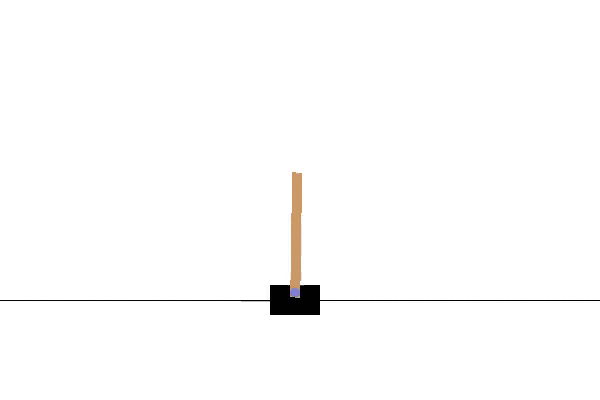
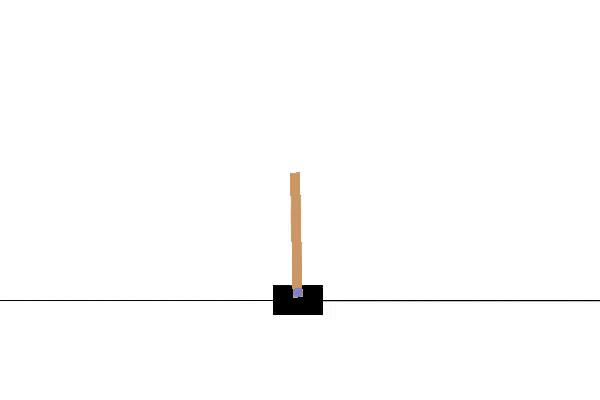
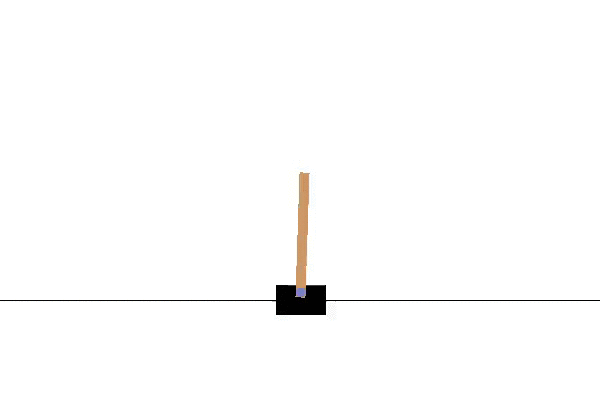

In [70]:
HTML(data=get_gif_html(env_videos=training_env.videos, title='Training evolution'))

# A3C

In [89]:
class FCAC(nn.Module):
    def __init__(self, 
                 input_dim, 
                 output_dim,
                 hidden_dims=(32,32), 
                 init_weight=0.003,
                 activation_fc=F.relu):
        super(FCAC, self).__init__()
        self.activation_fc = activation_fc

        self.input_layer = nn.Linear(input_dim, 
                                     hidden_dims[0])
        
        self.hidden_layers = nn.ModuleList()
        for i in range(len(hidden_dims)-1):
            hidden_layer = nn.Linear(
                hidden_dims[i], hidden_dims[i+1])
            self.hidden_layers.append(hidden_layer)
                
        self.policy_layer = nn.Linear(
            hidden_dims[-1], output_dim)
        self.value_layer = nn.Linear(
            hidden_dims[-1], 1)

        device = "cpu"
        if torch.cuda.is_available():
            device = "cuda:0"
        self.device = torch.device(device)
        self.to(self.device)
        
        self.policy_layer.weight.data.uniform_(
            -init_weight, init_weight)
        self.policy_layer.bias.data.uniform_(
            -init_weight, init_weight)
        self.value_layer.weight.data.uniform_(
            -init_weight, init_weight)
        self.value_layer.bias.data.uniform_(
            -init_weight, init_weight)


    def forward(self, state):
        x = state
        if not isinstance(x, torch.Tensor):
            x = torch.tensor(x, 
                             device=self.device, 
                             dtype=torch.float32)
            x = x.unsqueeze(0)
        x = self.activation_fc(self.input_layer(x))
        for hidden_layer in self.hidden_layers:
            x = self.activation_fc(hidden_layer(x))
        pref = self.policy_layer(x)
        value = self.value_layer(x)
        return F.log_softmax(pref, dim=-1), value
    
    def select_action(self, state):
        logp, value = self.forward(state)
        action = torch.exp(logp).multinomial(num_samples=1).data[0].cpu().numpy()[0]
        return action, logp, value

In [95]:
class A3CAgent():
    def __init__(self, model, optimizer, optimizer_lr):
        self.model_fn = model
        self.optimizer_fn = optimizer
        self.optimizer_lr = optimizer_lr
        self.print_every_episodes = 100

    def optimize_model(self):
        num_steps = len(self.rewards)
        discounts = np.logspace(0, num_steps, num=num_steps, base=self.gamma, endpoint=False)
        returns = []
        for step_idx in range(num_steps):
            last_idx = num_steps-step_idx
            # print('discounts', discounts[:last_idx])
            # print('future rewards', self.rewards[step_idx:])
            # print('discounted future rewards', discounts[:last_idx] * self.rewards[step_idx:])
            # print('sum of discounted future rewards', np.sum(discounts[:last_idx] * self.rewards[step_idx:]))
            returns.append(np.sum(discounts[:last_idx] * self.rewards[step_idx:]))

        self.logps = torch.cat(self.logps).cuda()
        self.actions = torch.LongTensor(self.actions)
        returns = torch.FloatTensor(returns).unsqueeze(1).cuda()
        self.values = torch.cat(self.values)
        
        value_error = returns - self.values
        value_loss = value_error.pow(2).mean()
        policy_loss = -(self.logps[np.arange(num_steps), self.actions] * value_error.detach()).sum()
        entropy_loss = (self.logps * torch.exp(self.logps)).sum()
        loss = policy_loss + 0.5 * value_loss + 0.01 * entropy_loss

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

    def interaction_step(self, env, state):
        action, logp, value = self.model.select_action(state)
        new_state, reward, is_terminal, _ = env.step(action)
        
        self.logps.append(logp)
        self.actions.append(action)
        self.rewards.append(reward)
        self.values.append(value)
        
        self.episode_reward[-1] += reward
        self.episode_timestep[-1] += 1
        
        return new_state, is_terminal

    def train(self, env, gamma, max_episodes, max_mean_reward):
        self.gamma = gamma
        nS, nA = env.observation_space.shape[0], env.action_space.n
        self.episode_exploration = []
        self.episode_timestep = []
        self.episode_reward = []
        self.episode_seconds = []
        
        self.model = self.model_fn(nS, nA)
        self.model.eval()
        self.optimizer = self.optimizer_fn(self.model, self.optimizer_lr)
        
        for episode in range(1, max_episodes + 1):
            start = time.time()
            state, is_terminal = env.reset(), False
            self.episode_reward.append(0.0)
            self.episode_timestep.append(0.0)
            self.episode_exploration.append(0.0)

            # collect rollout
            self.logps, self.actions, self.rewards, self.values = [], [], [], []
            for timestep in count(start=1):
                state, is_terminal = self.interaction_step(env, state)
                if is_terminal:
                    break
            self.optimize_model()

            # stats
            self.episode_seconds.append(time.time() - start)
            mean_seconds = np.mean(self.episode_seconds[-100:])
            mean_reward = np.mean(self.episode_reward[-100:])
            mean_10_reward = np.mean(self.episode_reward[-25:])
            if episode % self.print_every_episodes == 0 or mean_reward >= max_mean_reward:
                episode_exploration_ratio = self.episode_exploration[-1] / self.episode_timestep[-1]
                debug_message = 'ep {:03}, tmstps {:05}, explr rat {:.2f}, buf sze {:05}, '
                debug_message += '25/100 ep av rew {:06.2f}/{:06.2f}, 100 ep av sec {:.2f}'
                debug_message = debug_message.format(
                    episode, int(np.sum(self.episode_timestep)), 
                    1, 1, 
                    mean_10_reward, mean_reward, mean_seconds)
                print(debug_message)

            if mean_reward >= max_mean_reward:
                print('Training complete')
                break

        env.close()
        return self.episode_reward
    
    def evaluate(self, env, strategy, episodes=10, render=True):
        pass

In [ ]:
rewardss = []
for seed in [1, 2, 3 , 4, 5]:
    environment_settings = {
        'training_env_name': 'CartPole-v0',
        'testing_env_name': 'CartPole-v0',
        'gamma': 1.00,
        'max_episodes': 5000,
        'max_mean_reward': 195,
        'print_every_episodes': 25,
        'save_every_episodes': 1500,
        'n_evaluation_episodes': 10,
    }

    model = lambda nS, nA: FCAC(nS, nA, hidden_dims=(512,256))
    optimizer = lambda net, lr: optim.RMSprop(net.parameters(), lr=lr)
    optimizer_lr = 0.0001

    training_env_name, testing_env_name, gamma, max_episodes, \
      max_mean_reward, print_every_episodes, save_every_episodes, \
      n_evaluation_episodes = environment_settings.values()

    torch.manual_seed(seed)
    np.random.seed(seed)

    agent = A3CAgent(model, optimizer, optimizer_lr)

    training_env = make_monitored_env(training_env_name, 'training', seed)
    rewards = agent.train(training_env, gamma=gamma, max_episodes=max_episodes, max_mean_reward=max_mean_reward)
    rewardss.append(rewards)
mean_ep = 0
for r in rewardss:
    mean_ep += len(r)
mean_ep /= len(rewardss)
print("Mean num ep to pass {:.2f}".format(mean_ep))

/opt/conda/lib/python3.6/site-packages/gym/envs/registration.py:14: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)


ep 100, tmstps 03216, explr rat 1.00, buf sze 00001, 25/100 ep av rew 036.04/032.16, 100 ep av sec 0.05
ep 200, tmstps 06920, explr rat 1.00, buf sze 00001, 25/100 ep av rew 043.92/037.04, 100 ep av sec 0.03
ep 300, tmstps 12259, explr rat 1.00, buf sze 00001, 25/100 ep av rew 066.12/053.39, 100 ep av sec 0.04
ep 400, tmstps 18070, explr rat 1.00, buf sze 00001, 25/100 ep av rew 060.88/058.11, 100 ep av sec 0.05
ep 500, tmstps 25797, explr rat 1.00, buf sze 00001, 25/100 ep av rew 078.96/077.27, 100 ep av sec 0.05



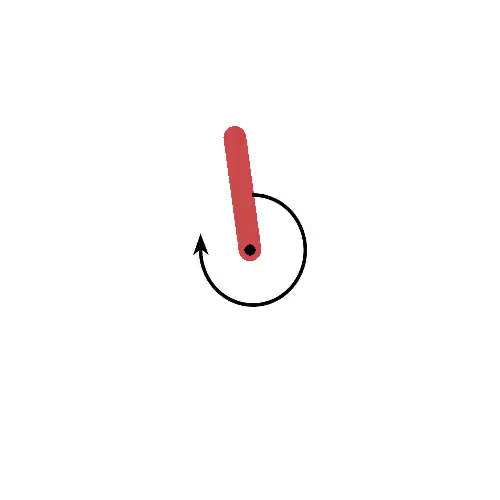
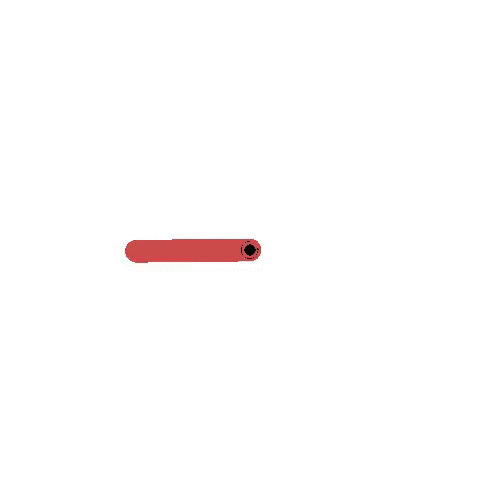
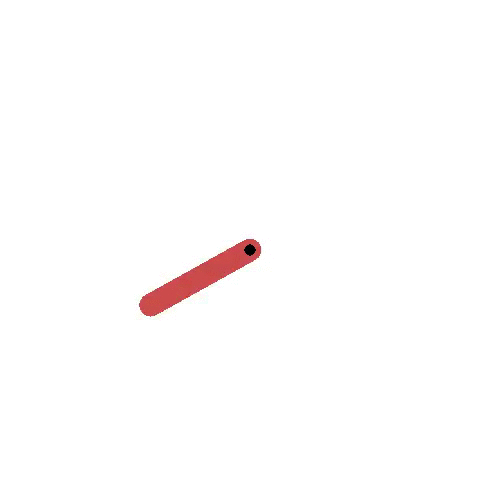

In [20]:
HTML(data=get_gif_html(env_videos=training_env.videos, title='Training evolution', max_n_videos=3))

# GAE

In [ ]:
rewardss = []
for seed in [1, 2, 3 , 4, 5]:
    environment_settings = {
        'training_env_name': 'CartPole-v0',
        'testing_env_name': 'CartPole-v0',
        'gamma': 1.00,
        'max_episodes': 5000,
        'max_mean_reward': 195,
        'print_every_episodes': 25,
        'save_every_episodes': 1500,
        'n_evaluation_episodes': 10,
    }

    policy_model = lambda nS, nA: FCDP(nS, nA, hidden_dims=(256,256))
    policy_optimizer = lambda net, lr: optim.Adam(net.parameters(), lr=lr)
    policy_optimizer_lr = 0.0003

    value_model = lambda nS: FCV(nS, hidden_dims=(512,256))
    value_optimizer = lambda net, lr: optim.RMSprop(net.parameters(), lr=lr)
    value_optimizer_lr = 0.005

    training_env_name, testing_env_name, gamma, max_episodes, \
      max_mean_reward, print_every_episodes, save_every_episodes, \
      n_evaluation_episodes = environment_settings.values()

    torch.manual_seed(seed)
    np.random.seed(seed)

    agent = VPGAgent(policy_model, policy_optimizer, policy_optimizer_lr,
                     value_model, value_optimizer, value_optimizer_lr)

    training_env = make_monitored_env(training_env_name, 'training', seed)
    rewards = agent.train(training_env, gamma=gamma, max_episodes=max_episodes, max_mean_reward=max_mean_reward)
    rewardss.append(rewards)
mean_ep = 0
for r in rewardss:
    mean_ep += len(r)
mean_ep /= len(rewardss)
print("Mean num ep to pass {:.2f}".format(mean_ep))

# A2C

In [ ]:
rewardss = []
for seed in [1, 2, 3 , 4, 5]:
    environment_settings = {
        'training_env_name': 'CartPole-v0',
        'testing_env_name': 'CartPole-v0',
        'gamma': 1.00,
        'max_episodes': 5000,
        'max_mean_reward': 195,
        'print_every_episodes': 25,
        'save_every_episodes': 1500,
        'n_evaluation_episodes': 10,
    }

    policy_model = lambda nS, nA: FCDP(nS, nA, hidden_dims=(256,256))
    policy_optimizer = lambda net, lr: optim.Adam(net.parameters(), lr=lr)
    policy_optimizer_lr = 0.0003

    value_model = lambda nS: FCV(nS, hidden_dims=(512,256))
    value_optimizer = lambda net, lr: optim.RMSprop(net.parameters(), lr=lr)
    value_optimizer_lr = 0.005

    training_env_name, testing_env_name, gamma, max_episodes, \
      max_mean_reward, print_every_episodes, save_every_episodes, \
      n_evaluation_episodes = environment_settings.values()

    torch.manual_seed(seed)
    np.random.seed(seed)

    agent = VPGAgent(policy_model, policy_optimizer, policy_optimizer_lr,
                     value_model, value_optimizer, value_optimizer_lr)

    training_env = make_monitored_env(training_env_name, 'training', seed)
    rewards = agent.train(training_env, gamma=gamma, max_episodes=max_episodes, max_mean_reward=max_mean_reward)
    rewardss.append(rewards)
mean_ep = 0
for r in rewardss:
    mean_ep += len(r)
mean_ep /= len(rewardss)
print("Mean num ep to pass {:.2f}".format(mean_ep))

In [ ]:
HTML(data=get_gif_html(env_videos=training_env.videos, title='Training evolution', max_n_videos=3))